# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

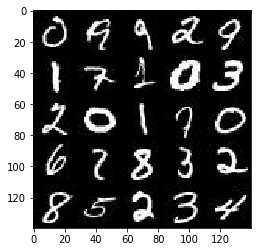

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

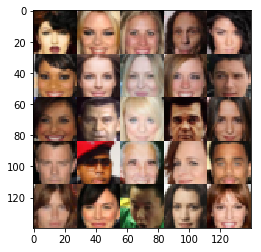

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images=tf.placeholder(tf.float32,[None, image_width, image_height, image_channels])
    inputs_z=tf.placeholder(tf.float32,[None,  z_dim])
    learning_rate=tf.placeholder(tf.float32)
    
    return input_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def lrelu(x, alpha):
    return tf.maximum(x*alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    kinit = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # 14*14*64
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding="same")
        conv1 = lrelu(conv1, alpha)
        conv1 = tf.nn.dropout(conv1, 0.8)
        
        # 7*7*128
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, kernel_initializer=kinit, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = lrelu(conv2, alpha)
        conv2 = tf.nn.dropout(conv2, 0.8)
        
        # 4*4*256
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, kernel_initializer=kinit, padding="same")
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = lrelu(conv3, alpha)
        conv3 = tf.nn.dropout(conv3, 0.8)
        
        conv3 =  tf.contrib.layers.flatten(conv3)
        logits = tf.layers.dense(conv3,1)
        output = tf.tanh(logits)
        
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("generator", reuse=(not is_train)):
        z = tf.layers.dense(z, 7*7*512)
        z = tf.reshape(z, (-1,7,7,512))
        z = tf.layers.batch_normalization(z, training=is_train)
        z = lrelu(z, alpha)
        #7*7
        
        conv1 = tf.layers.conv2d_transpose(z, 512, 4, strides=2, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = lrelu(conv1, alpha)
        conv1 = tf.layers.dropout(conv1, rate=0.5, training=is_train)
        #14*14
        
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 4, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = lrelu(conv2, alpha)
        conv2 = tf.layers.dropout(conv2, rate=0.5, training=is_train)
        #28*28
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 4, strides=1, padding="same")
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = lrelu(conv3, alpha)
        conv3 = tf.layers.dropout(conv3, rate=0.5, training=is_train)
        #28*28
        
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 4, strides=1, padding="same")
        
        output=tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every=50
    print_every=10
    step=0
    
    out_channel_dim = 1 if (data_image_mode == "L") else 3
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1   
                
                batch_images *=  2
                batch_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} - Step {}".format(epoch_i+1, epochs, step), "Discriminator Loss: {:.4f} ".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))
                if step % show_every == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Step 10 Discriminator Loss: 1.9183  Generator Loss: 1.1137
Epoch 1/2 - Step 20 Discriminator Loss: 2.4696  Generator Loss: 0.4637
Epoch 1/2 - Step 30 Discriminator Loss: 1.7911  Generator Loss: 0.4241
Epoch 1/2 - Step 40 Discriminator Loss: 1.6304  Generator Loss: 0.7939
Epoch 1/2 - Step 50 Discriminator Loss: 1.6141  Generator Loss: 0.9937


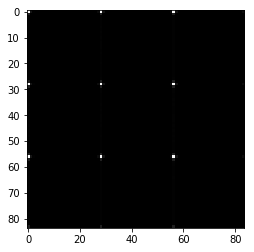

Epoch 1/2 - Step 60 Discriminator Loss: 2.0908  Generator Loss: 0.5333
Epoch 1/2 - Step 70 Discriminator Loss: 1.6936  Generator Loss: 0.7967
Epoch 1/2 - Step 80 Discriminator Loss: 1.8380  Generator Loss: 0.8961
Epoch 1/2 - Step 90 Discriminator Loss: 1.3602  Generator Loss: 0.8995
Epoch 1/2 - Step 100 Discriminator Loss: 1.5575  Generator Loss: 0.5489


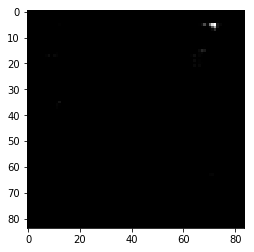

Epoch 1/2 - Step 110 Discriminator Loss: 1.5637  Generator Loss: 0.6821
Epoch 1/2 - Step 120 Discriminator Loss: 1.3366  Generator Loss: 1.2972
Epoch 1/2 - Step 130 Discriminator Loss: 1.6989  Generator Loss: 0.3508
Epoch 1/2 - Step 140 Discriminator Loss: 1.7153  Generator Loss: 0.4310
Epoch 1/2 - Step 150 Discriminator Loss: 1.5489  Generator Loss: 0.5713


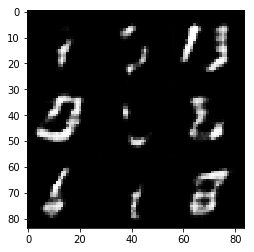

Epoch 1/2 - Step 160 Discriminator Loss: 1.6005  Generator Loss: 0.6181
Epoch 1/2 - Step 170 Discriminator Loss: 1.5860  Generator Loss: 0.6006
Epoch 1/2 - Step 180 Discriminator Loss: 1.5175  Generator Loss: 0.9146
Epoch 1/2 - Step 190 Discriminator Loss: 1.7079  Generator Loss: 1.0147
Epoch 1/2 - Step 200 Discriminator Loss: 1.5836  Generator Loss: 0.5660


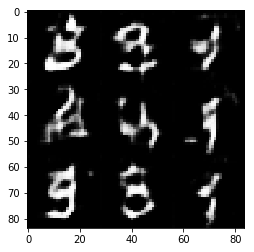

Epoch 1/2 - Step 210 Discriminator Loss: 1.5424  Generator Loss: 0.7164
Epoch 1/2 - Step 220 Discriminator Loss: 1.6305  Generator Loss: 0.6501
Epoch 1/2 - Step 230 Discriminator Loss: 1.4623  Generator Loss: 0.7738
Epoch 1/2 - Step 240 Discriminator Loss: 1.5257  Generator Loss: 1.0124
Epoch 1/2 - Step 250 Discriminator Loss: 1.4653  Generator Loss: 0.6598


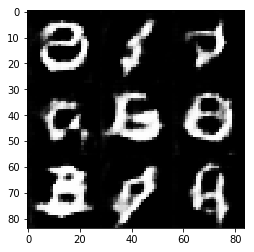

Epoch 1/2 - Step 260 Discriminator Loss: 1.4348  Generator Loss: 0.7489
Epoch 1/2 - Step 270 Discriminator Loss: 1.5015  Generator Loss: 0.7766
Epoch 1/2 - Step 280 Discriminator Loss: 1.4021  Generator Loss: 0.8667
Epoch 1/2 - Step 290 Discriminator Loss: 1.4286  Generator Loss: 0.5781
Epoch 1/2 - Step 300 Discriminator Loss: 1.4738  Generator Loss: 0.5665


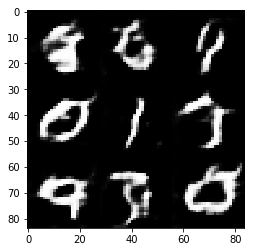

Epoch 1/2 - Step 310 Discriminator Loss: 1.4301  Generator Loss: 0.6990
Epoch 1/2 - Step 320 Discriminator Loss: 1.3907  Generator Loss: 0.9020
Epoch 1/2 - Step 330 Discriminator Loss: 1.6809  Generator Loss: 0.4588
Epoch 1/2 - Step 340 Discriminator Loss: 1.5657  Generator Loss: 0.5233
Epoch 1/2 - Step 350 Discriminator Loss: 1.4107  Generator Loss: 0.8442


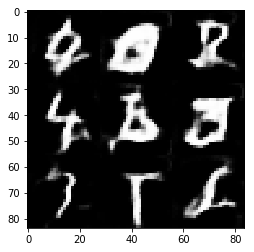

Epoch 1/2 - Step 360 Discriminator Loss: 1.3623  Generator Loss: 0.7723
Epoch 1/2 - Step 370 Discriminator Loss: 1.5232  Generator Loss: 0.5900
Epoch 1/2 - Step 380 Discriminator Loss: 1.4717  Generator Loss: 1.0088
Epoch 1/2 - Step 390 Discriminator Loss: 1.5022  Generator Loss: 1.1308
Epoch 1/2 - Step 400 Discriminator Loss: 1.5448  Generator Loss: 0.5690


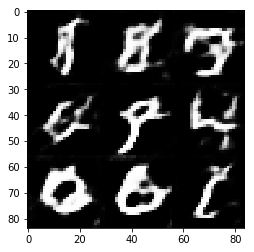

Epoch 1/2 - Step 410 Discriminator Loss: 1.4674  Generator Loss: 0.5486
Epoch 1/2 - Step 420 Discriminator Loss: 1.4864  Generator Loss: 0.9895
Epoch 1/2 - Step 430 Discriminator Loss: 1.3780  Generator Loss: 0.9110
Epoch 1/2 - Step 440 Discriminator Loss: 1.4248  Generator Loss: 0.9223
Epoch 1/2 - Step 450 Discriminator Loss: 1.4709  Generator Loss: 1.0410


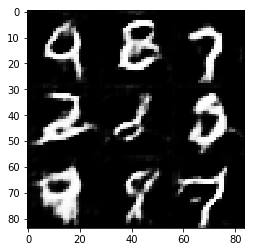

Epoch 1/2 - Step 460 Discriminator Loss: 1.4065  Generator Loss: 0.7267
Epoch 1/2 - Step 470 Discriminator Loss: 1.5224  Generator Loss: 1.1729
Epoch 1/2 - Step 480 Discriminator Loss: 1.4784  Generator Loss: 0.7644
Epoch 1/2 - Step 490 Discriminator Loss: 1.4962  Generator Loss: 0.6959
Epoch 1/2 - Step 500 Discriminator Loss: 1.5211  Generator Loss: 0.6978


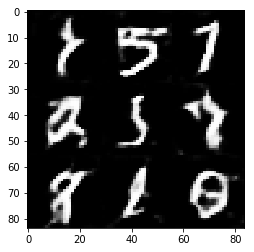

Epoch 1/2 - Step 510 Discriminator Loss: 1.3831  Generator Loss: 1.0002
Epoch 1/2 - Step 520 Discriminator Loss: 1.4019  Generator Loss: 1.0771
Epoch 1/2 - Step 530 Discriminator Loss: 1.4739  Generator Loss: 0.7139
Epoch 1/2 - Step 540 Discriminator Loss: 1.5281  Generator Loss: 0.5011
Epoch 1/2 - Step 550 Discriminator Loss: 1.4592  Generator Loss: 0.9572


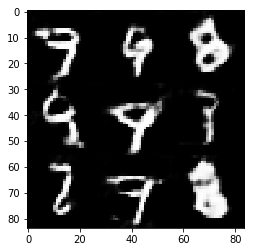

Epoch 1/2 - Step 560 Discriminator Loss: 1.4117  Generator Loss: 0.8866
Epoch 1/2 - Step 570 Discriminator Loss: 1.3830  Generator Loss: 0.9138
Epoch 1/2 - Step 580 Discriminator Loss: 1.5605  Generator Loss: 0.4623
Epoch 1/2 - Step 590 Discriminator Loss: 1.4063  Generator Loss: 0.9210
Epoch 1/2 - Step 600 Discriminator Loss: 1.4249  Generator Loss: 0.7308


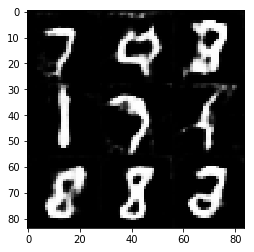

Epoch 1/2 - Step 610 Discriminator Loss: 1.4773  Generator Loss: 0.6873
Epoch 1/2 - Step 620 Discriminator Loss: 1.4268  Generator Loss: 0.6414
Epoch 1/2 - Step 630 Discriminator Loss: 1.4388  Generator Loss: 1.0063
Epoch 1/2 - Step 640 Discriminator Loss: 1.4021  Generator Loss: 0.8800
Epoch 1/2 - Step 650 Discriminator Loss: 1.5608  Generator Loss: 0.5387


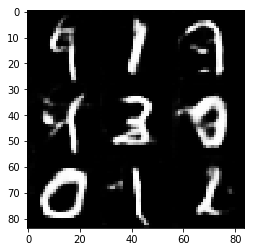

Epoch 1/2 - Step 660 Discriminator Loss: 1.4959  Generator Loss: 0.9176
Epoch 1/2 - Step 670 Discriminator Loss: 1.3687  Generator Loss: 0.7663
Epoch 1/2 - Step 680 Discriminator Loss: 1.4790  Generator Loss: 0.5909
Epoch 1/2 - Step 690 Discriminator Loss: 1.4033  Generator Loss: 0.8817
Epoch 1/2 - Step 700 Discriminator Loss: 1.3633  Generator Loss: 0.5910


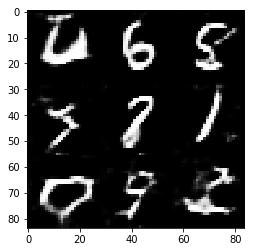

Epoch 1/2 - Step 710 Discriminator Loss: 1.4636  Generator Loss: 0.5876
Epoch 1/2 - Step 720 Discriminator Loss: 1.3922  Generator Loss: 0.8076
Epoch 1/2 - Step 730 Discriminator Loss: 1.4450  Generator Loss: 0.7789
Epoch 1/2 - Step 740 Discriminator Loss: 1.4983  Generator Loss: 0.5371
Epoch 1/2 - Step 750 Discriminator Loss: 1.3978  Generator Loss: 0.6816


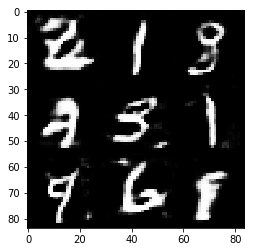

Epoch 1/2 - Step 760 Discriminator Loss: 1.3492  Generator Loss: 0.9818
Epoch 1/2 - Step 770 Discriminator Loss: 1.3605  Generator Loss: 0.6167
Epoch 1/2 - Step 780 Discriminator Loss: 1.4074  Generator Loss: 0.6376
Epoch 1/2 - Step 790 Discriminator Loss: 1.4065  Generator Loss: 0.9667
Epoch 1/2 - Step 800 Discriminator Loss: 1.4369  Generator Loss: 0.8072


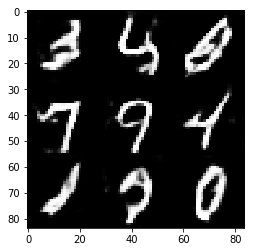

Epoch 1/2 - Step 810 Discriminator Loss: 1.4361  Generator Loss: 0.5231
Epoch 1/2 - Step 820 Discriminator Loss: 1.3305  Generator Loss: 0.8268
Epoch 1/2 - Step 830 Discriminator Loss: 1.4109  Generator Loss: 1.1779
Epoch 1/2 - Step 840 Discriminator Loss: 1.4415  Generator Loss: 0.6369
Epoch 1/2 - Step 850 Discriminator Loss: 1.4360  Generator Loss: 0.6936


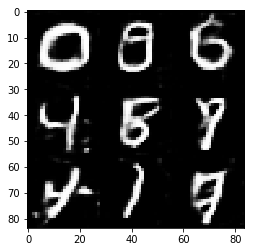

Epoch 1/2 - Step 860 Discriminator Loss: 1.5001  Generator Loss: 0.5191
Epoch 1/2 - Step 870 Discriminator Loss: 1.3825  Generator Loss: 0.9553
Epoch 1/2 - Step 880 Discriminator Loss: 1.3787  Generator Loss: 0.6662
Epoch 1/2 - Step 890 Discriminator Loss: 1.3960  Generator Loss: 0.9438
Epoch 1/2 - Step 900 Discriminator Loss: 1.4608  Generator Loss: 1.0523


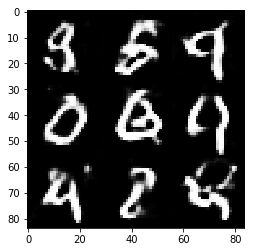

Epoch 1/2 - Step 910 Discriminator Loss: 1.4616  Generator Loss: 0.5782
Epoch 1/2 - Step 920 Discriminator Loss: 1.3765  Generator Loss: 0.6250
Epoch 1/2 - Step 930 Discriminator Loss: 1.3687  Generator Loss: 0.7683
Epoch 2/2 - Step 940 Discriminator Loss: 1.3575  Generator Loss: 0.6406
Epoch 2/2 - Step 950 Discriminator Loss: 1.4251  Generator Loss: 0.5582


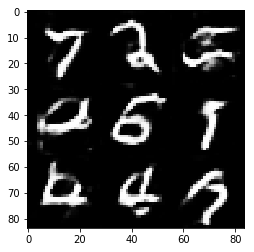

Epoch 2/2 - Step 960 Discriminator Loss: 1.3536  Generator Loss: 0.6804
Epoch 2/2 - Step 970 Discriminator Loss: 1.4490  Generator Loss: 1.1978
Epoch 2/2 - Step 980 Discriminator Loss: 1.3510  Generator Loss: 0.8874
Epoch 2/2 - Step 990 Discriminator Loss: 1.3802  Generator Loss: 0.8611
Epoch 2/2 - Step 1000 Discriminator Loss: 1.4418  Generator Loss: 0.5295


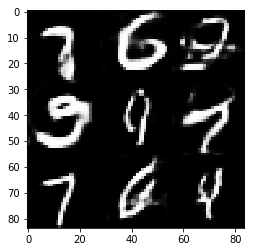

Epoch 2/2 - Step 1010 Discriminator Loss: 1.3225  Generator Loss: 0.7827
Epoch 2/2 - Step 1020 Discriminator Loss: 1.3986  Generator Loss: 0.5793
Epoch 2/2 - Step 1030 Discriminator Loss: 1.3697  Generator Loss: 0.7444
Epoch 2/2 - Step 1040 Discriminator Loss: 1.3575  Generator Loss: 0.7223
Epoch 2/2 - Step 1050 Discriminator Loss: 1.3178  Generator Loss: 0.7312


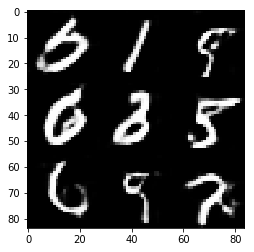

Epoch 2/2 - Step 1060 Discriminator Loss: 1.4976  Generator Loss: 1.3054
Epoch 2/2 - Step 1070 Discriminator Loss: 1.4053  Generator Loss: 0.6321
Epoch 2/2 - Step 1080 Discriminator Loss: 1.3721  Generator Loss: 0.8181
Epoch 2/2 - Step 1090 Discriminator Loss: 1.5277  Generator Loss: 1.3120
Epoch 2/2 - Step 1100 Discriminator Loss: 1.4213  Generator Loss: 0.7947


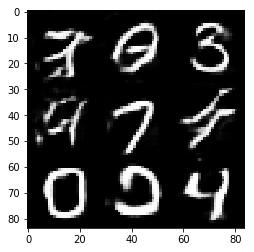

Epoch 2/2 - Step 1110 Discriminator Loss: 1.3198  Generator Loss: 0.8478
Epoch 2/2 - Step 1120 Discriminator Loss: 1.3683  Generator Loss: 0.7058
Epoch 2/2 - Step 1130 Discriminator Loss: 1.4227  Generator Loss: 1.0097
Epoch 2/2 - Step 1140 Discriminator Loss: 1.4428  Generator Loss: 0.7040
Epoch 2/2 - Step 1150 Discriminator Loss: 1.4399  Generator Loss: 0.5241


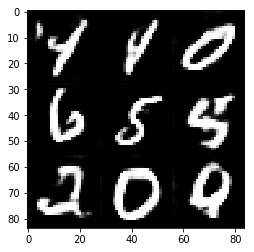

Epoch 2/2 - Step 1160 Discriminator Loss: 1.3639  Generator Loss: 0.6594
Epoch 2/2 - Step 1170 Discriminator Loss: 1.3680  Generator Loss: 0.7036
Epoch 2/2 - Step 1180 Discriminator Loss: 1.4529  Generator Loss: 0.5020
Epoch 2/2 - Step 1190 Discriminator Loss: 1.3949  Generator Loss: 0.6768
Epoch 2/2 - Step 1200 Discriminator Loss: 1.4762  Generator Loss: 1.2502


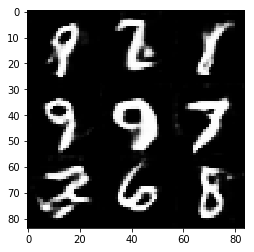

Epoch 2/2 - Step 1210 Discriminator Loss: 1.3577  Generator Loss: 0.7926
Epoch 2/2 - Step 1220 Discriminator Loss: 1.3508  Generator Loss: 0.9577
Epoch 2/2 - Step 1230 Discriminator Loss: 1.4197  Generator Loss: 0.5926
Epoch 2/2 - Step 1240 Discriminator Loss: 1.4126  Generator Loss: 1.0201
Epoch 2/2 - Step 1250 Discriminator Loss: 1.3074  Generator Loss: 1.0593


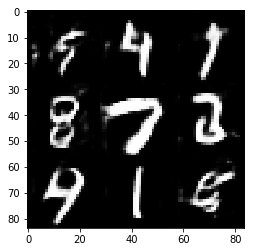

Epoch 2/2 - Step 1260 Discriminator Loss: 1.3827  Generator Loss: 0.7336
Epoch 2/2 - Step 1270 Discriminator Loss: 1.6131  Generator Loss: 1.5798
Epoch 2/2 - Step 1280 Discriminator Loss: 1.3016  Generator Loss: 0.7963
Epoch 2/2 - Step 1290 Discriminator Loss: 1.3927  Generator Loss: 1.0657
Epoch 2/2 - Step 1300 Discriminator Loss: 1.3778  Generator Loss: 0.8958


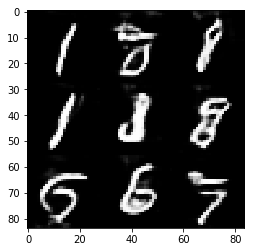

Epoch 2/2 - Step 1310 Discriminator Loss: 1.3163  Generator Loss: 0.8603
Epoch 2/2 - Step 1320 Discriminator Loss: 1.3395  Generator Loss: 0.9169
Epoch 2/2 - Step 1330 Discriminator Loss: 1.3630  Generator Loss: 0.6784
Epoch 2/2 - Step 1340 Discriminator Loss: 1.2980  Generator Loss: 0.8559
Epoch 2/2 - Step 1350 Discriminator Loss: 1.2380  Generator Loss: 0.9673


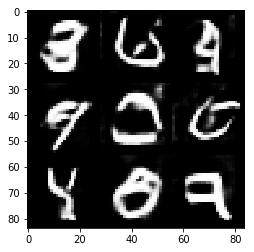

Epoch 2/2 - Step 1360 Discriminator Loss: 1.5383  Generator Loss: 0.4490
Epoch 2/2 - Step 1370 Discriminator Loss: 1.4515  Generator Loss: 0.8112
Epoch 2/2 - Step 1380 Discriminator Loss: 1.3787  Generator Loss: 1.0248
Epoch 2/2 - Step 1390 Discriminator Loss: 1.4767  Generator Loss: 0.5489
Epoch 2/2 - Step 1400 Discriminator Loss: 1.3237  Generator Loss: 1.0789


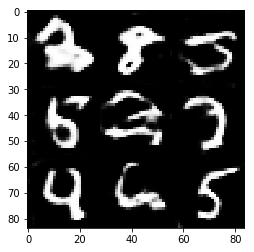

Epoch 2/2 - Step 1410 Discriminator Loss: 1.5393  Generator Loss: 0.5143
Epoch 2/2 - Step 1420 Discriminator Loss: 1.4898  Generator Loss: 1.1242
Epoch 2/2 - Step 1430 Discriminator Loss: 1.3435  Generator Loss: 0.8653
Epoch 2/2 - Step 1440 Discriminator Loss: 1.2743  Generator Loss: 0.8053
Epoch 2/2 - Step 1450 Discriminator Loss: 1.3807  Generator Loss: 0.7729


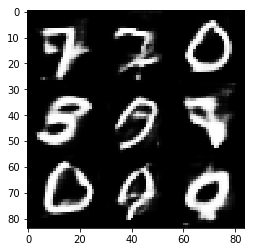

Epoch 2/2 - Step 1460 Discriminator Loss: 1.2604  Generator Loss: 0.7249
Epoch 2/2 - Step 1470 Discriminator Loss: 1.3496  Generator Loss: 0.9487
Epoch 2/2 - Step 1480 Discriminator Loss: 1.4215  Generator Loss: 0.9557
Epoch 2/2 - Step 1490 Discriminator Loss: 1.3564  Generator Loss: 0.8683
Epoch 2/2 - Step 1500 Discriminator Loss: 1.3215  Generator Loss: 0.9758


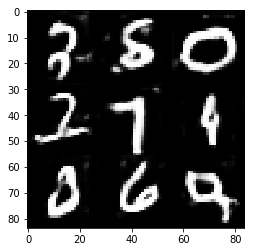

Epoch 2/2 - Step 1510 Discriminator Loss: 1.6593  Generator Loss: 0.3977
Epoch 2/2 - Step 1520 Discriminator Loss: 1.3929  Generator Loss: 0.9216
Epoch 2/2 - Step 1530 Discriminator Loss: 1.3636  Generator Loss: 0.7045
Epoch 2/2 - Step 1540 Discriminator Loss: 1.3491  Generator Loss: 0.7282
Epoch 2/2 - Step 1550 Discriminator Loss: 1.4199  Generator Loss: 0.5471


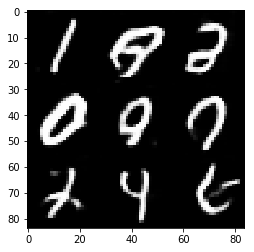

Epoch 2/2 - Step 1560 Discriminator Loss: 1.3455  Generator Loss: 0.7710
Epoch 2/2 - Step 1570 Discriminator Loss: 1.4123  Generator Loss: 0.6481
Epoch 2/2 - Step 1580 Discriminator Loss: 1.3484  Generator Loss: 1.0578
Epoch 2/2 - Step 1590 Discriminator Loss: 1.4654  Generator Loss: 1.2994
Epoch 2/2 - Step 1600 Discriminator Loss: 1.2898  Generator Loss: 0.8410


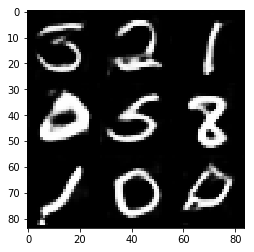

Epoch 2/2 - Step 1610 Discriminator Loss: 1.3623  Generator Loss: 0.8266
Epoch 2/2 - Step 1620 Discriminator Loss: 1.2895  Generator Loss: 0.7976
Epoch 2/2 - Step 1630 Discriminator Loss: 1.3047  Generator Loss: 0.7291
Epoch 2/2 - Step 1640 Discriminator Loss: 1.3483  Generator Loss: 1.3393
Epoch 2/2 - Step 1650 Discriminator Loss: 1.3124  Generator Loss: 0.7127


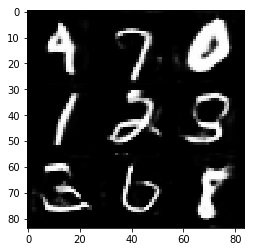

Epoch 2/2 - Step 1660 Discriminator Loss: 1.4239  Generator Loss: 1.0538
Epoch 2/2 - Step 1670 Discriminator Loss: 1.4731  Generator Loss: 0.6087
Epoch 2/2 - Step 1680 Discriminator Loss: 1.3956  Generator Loss: 1.1953
Epoch 2/2 - Step 1690 Discriminator Loss: 1.2805  Generator Loss: 0.8824
Epoch 2/2 - Step 1700 Discriminator Loss: 1.3451  Generator Loss: 0.6577


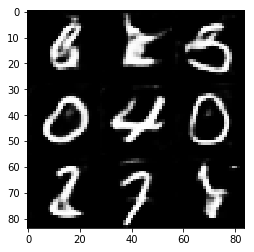

Epoch 2/2 - Step 1710 Discriminator Loss: 1.2753  Generator Loss: 1.0437
Epoch 2/2 - Step 1720 Discriminator Loss: 1.3127  Generator Loss: 0.8594
Epoch 2/2 - Step 1730 Discriminator Loss: 1.4085  Generator Loss: 0.7774
Epoch 2/2 - Step 1740 Discriminator Loss: 1.3159  Generator Loss: 0.8213
Epoch 2/2 - Step 1750 Discriminator Loss: 1.2527  Generator Loss: 0.8417


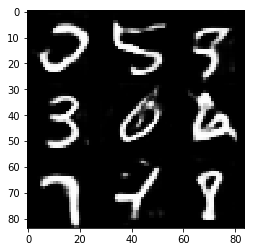

Epoch 2/2 - Step 1760 Discriminator Loss: 1.4156  Generator Loss: 1.0168
Epoch 2/2 - Step 1770 Discriminator Loss: 1.2630  Generator Loss: 0.7011
Epoch 2/2 - Step 1780 Discriminator Loss: 1.3231  Generator Loss: 0.8869
Epoch 2/2 - Step 1790 Discriminator Loss: 1.3713  Generator Loss: 0.9356
Epoch 2/2 - Step 1800 Discriminator Loss: 1.2888  Generator Loss: 0.9828


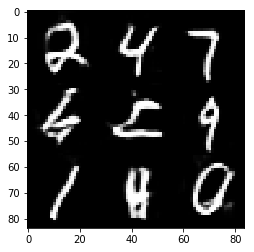

Epoch 2/2 - Step 1810 Discriminator Loss: 1.2466  Generator Loss: 0.9794
Epoch 2/2 - Step 1820 Discriminator Loss: 1.3423  Generator Loss: 0.9080
Epoch 2/2 - Step 1830 Discriminator Loss: 1.3921  Generator Loss: 0.7869
Epoch 2/2 - Step 1840 Discriminator Loss: 1.3669  Generator Loss: 0.9225
Epoch 2/2 - Step 1850 Discriminator Loss: 1.4021  Generator Loss: 1.0342


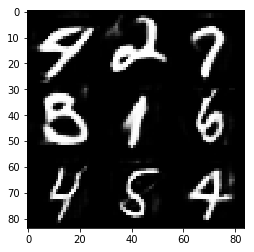

Epoch 2/2 - Step 1860 Discriminator Loss: 1.2802  Generator Loss: 0.8139
Epoch 2/2 - Step 1870 Discriminator Loss: 1.3515  Generator Loss: 0.6297


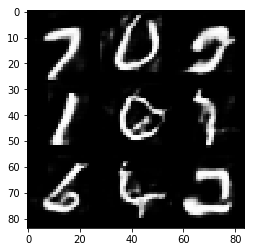

In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Step 10 Discriminator Loss: 2.8013  Generator Loss: 1.7413
Epoch 1/1 - Step 20 Discriminator Loss: 1.4180  Generator Loss: 1.3784
Epoch 1/1 - Step 30 Discriminator Loss: 1.1712  Generator Loss: 2.8111
Epoch 1/1 - Step 40 Discriminator Loss: 1.3469  Generator Loss: 2.4568
Epoch 1/1 - Step 50 Discriminator Loss: 1.6628  Generator Loss: 2.8170


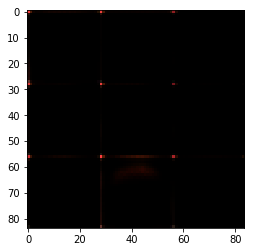

Epoch 1/1 - Step 60 Discriminator Loss: 1.7397  Generator Loss: 0.5107
Epoch 1/1 - Step 70 Discriminator Loss: 1.5688  Generator Loss: 0.9449
Epoch 1/1 - Step 80 Discriminator Loss: 1.8927  Generator Loss: 0.5393
Epoch 1/1 - Step 90 Discriminator Loss: 1.9176  Generator Loss: 0.9378
Epoch 1/1 - Step 100 Discriminator Loss: 1.7451  Generator Loss: 0.5669


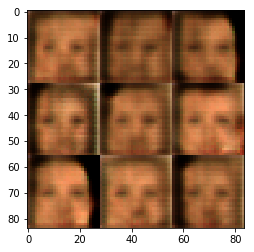

Epoch 1/1 - Step 110 Discriminator Loss: 1.4531  Generator Loss: 0.9735
Epoch 1/1 - Step 120 Discriminator Loss: 1.7346  Generator Loss: 0.6657
Epoch 1/1 - Step 130 Discriminator Loss: 1.6026  Generator Loss: 0.7616
Epoch 1/1 - Step 140 Discriminator Loss: 1.7407  Generator Loss: 0.7627
Epoch 1/1 - Step 150 Discriminator Loss: 1.4967  Generator Loss: 0.6333


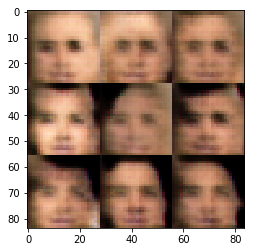

Epoch 1/1 - Step 160 Discriminator Loss: 1.4286  Generator Loss: 0.6727
Epoch 1/1 - Step 170 Discriminator Loss: 1.5595  Generator Loss: 0.9010
Epoch 1/1 - Step 180 Discriminator Loss: 1.4452  Generator Loss: 0.6796
Epoch 1/1 - Step 190 Discriminator Loss: 1.6499  Generator Loss: 0.9853
Epoch 1/1 - Step 200 Discriminator Loss: 1.5871  Generator Loss: 0.6362


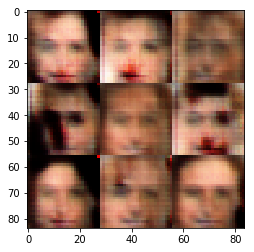

Epoch 1/1 - Step 210 Discriminator Loss: 1.5407  Generator Loss: 0.6622
Epoch 1/1 - Step 220 Discriminator Loss: 1.4559  Generator Loss: 0.7849
Epoch 1/1 - Step 230 Discriminator Loss: 1.6927  Generator Loss: 0.4060
Epoch 1/1 - Step 240 Discriminator Loss: 1.4536  Generator Loss: 0.8524
Epoch 1/1 - Step 250 Discriminator Loss: 1.3876  Generator Loss: 0.6806


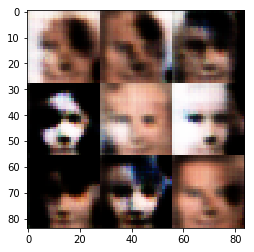

Epoch 1/1 - Step 260 Discriminator Loss: 1.7752  Generator Loss: 0.8926
Epoch 1/1 - Step 270 Discriminator Loss: 1.4734  Generator Loss: 0.7675
Epoch 1/1 - Step 280 Discriminator Loss: 1.4949  Generator Loss: 0.5782
Epoch 1/1 - Step 290 Discriminator Loss: 1.4598  Generator Loss: 0.7026
Epoch 1/1 - Step 300 Discriminator Loss: 1.5147  Generator Loss: 0.6128


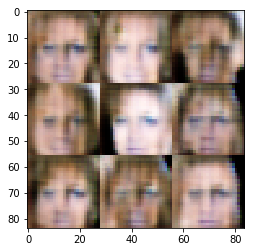

Epoch 1/1 - Step 310 Discriminator Loss: 1.4483  Generator Loss: 0.7583
Epoch 1/1 - Step 320 Discriminator Loss: 1.5595  Generator Loss: 0.6575
Epoch 1/1 - Step 330 Discriminator Loss: 1.4600  Generator Loss: 0.8435
Epoch 1/1 - Step 340 Discriminator Loss: 1.4578  Generator Loss: 0.8718
Epoch 1/1 - Step 350 Discriminator Loss: 1.4668  Generator Loss: 0.8935


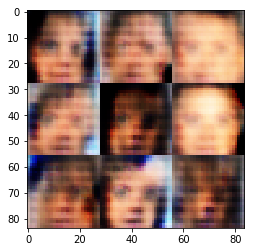

Epoch 1/1 - Step 360 Discriminator Loss: 1.4474  Generator Loss: 0.7301
Epoch 1/1 - Step 370 Discriminator Loss: 1.5525  Generator Loss: 0.6334
Epoch 1/1 - Step 380 Discriminator Loss: 1.4418  Generator Loss: 0.9182
Epoch 1/1 - Step 390 Discriminator Loss: 1.5216  Generator Loss: 0.8180
Epoch 1/1 - Step 400 Discriminator Loss: 1.3931  Generator Loss: 0.9271


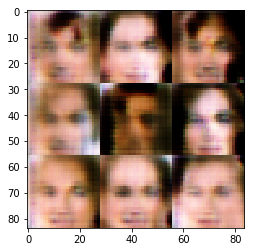

Epoch 1/1 - Step 410 Discriminator Loss: 1.4969  Generator Loss: 0.8377
Epoch 1/1 - Step 420 Discriminator Loss: 1.5282  Generator Loss: 0.7444
Epoch 1/1 - Step 430 Discriminator Loss: 1.7209  Generator Loss: 0.8840
Epoch 1/1 - Step 440 Discriminator Loss: 1.6745  Generator Loss: 0.6501
Epoch 1/1 - Step 450 Discriminator Loss: 1.6316  Generator Loss: 0.7705


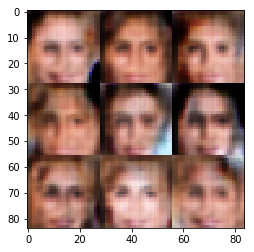

Epoch 1/1 - Step 460 Discriminator Loss: 1.5013  Generator Loss: 0.8231
Epoch 1/1 - Step 470 Discriminator Loss: 1.3900  Generator Loss: 0.8793
Epoch 1/1 - Step 480 Discriminator Loss: 1.4395  Generator Loss: 0.8001
Epoch 1/1 - Step 490 Discriminator Loss: 1.5015  Generator Loss: 0.6814
Epoch 1/1 - Step 500 Discriminator Loss: 1.5080  Generator Loss: 0.9614


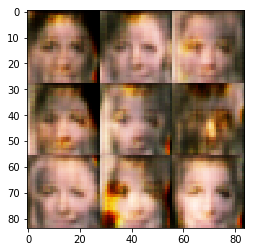

Epoch 1/1 - Step 510 Discriminator Loss: 1.4344  Generator Loss: 1.0127
Epoch 1/1 - Step 520 Discriminator Loss: 1.5551  Generator Loss: 0.6503
Epoch 1/1 - Step 530 Discriminator Loss: 1.4828  Generator Loss: 0.8090
Epoch 1/1 - Step 540 Discriminator Loss: 1.4173  Generator Loss: 0.6270
Epoch 1/1 - Step 550 Discriminator Loss: 1.5407  Generator Loss: 0.5651


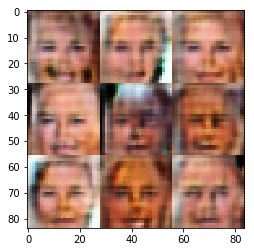

Epoch 1/1 - Step 560 Discriminator Loss: 1.4505  Generator Loss: 0.7057
Epoch 1/1 - Step 570 Discriminator Loss: 1.4901  Generator Loss: 0.7486
Epoch 1/1 - Step 580 Discriminator Loss: 1.5244  Generator Loss: 0.6781
Epoch 1/1 - Step 590 Discriminator Loss: 1.4709  Generator Loss: 0.6936
Epoch 1/1 - Step 600 Discriminator Loss: 1.4216  Generator Loss: 0.7545


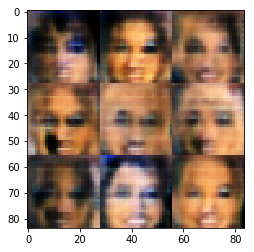

Epoch 1/1 - Step 610 Discriminator Loss: 1.5220  Generator Loss: 0.6525
Epoch 1/1 - Step 620 Discriminator Loss: 1.5754  Generator Loss: 1.0727
Epoch 1/1 - Step 630 Discriminator Loss: 1.4486  Generator Loss: 0.8172
Epoch 1/1 - Step 640 Discriminator Loss: 1.4997  Generator Loss: 0.6372
Epoch 1/1 - Step 650 Discriminator Loss: 1.4476  Generator Loss: 0.7825


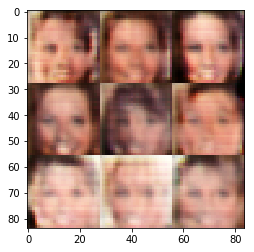

Epoch 1/1 - Step 660 Discriminator Loss: 1.4200  Generator Loss: 0.6575
Epoch 1/1 - Step 670 Discriminator Loss: 1.3618  Generator Loss: 0.7726
Epoch 1/1 - Step 680 Discriminator Loss: 1.4761  Generator Loss: 0.6893
Epoch 1/1 - Step 690 Discriminator Loss: 1.4614  Generator Loss: 0.7288
Epoch 1/1 - Step 700 Discriminator Loss: 1.4611  Generator Loss: 0.7487


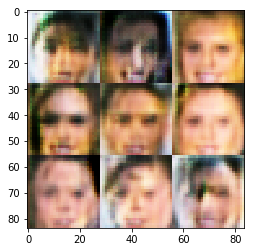

Epoch 1/1 - Step 710 Discriminator Loss: 1.4185  Generator Loss: 0.7862
Epoch 1/1 - Step 720 Discriminator Loss: 1.4590  Generator Loss: 0.7415
Epoch 1/1 - Step 730 Discriminator Loss: 1.4164  Generator Loss: 0.9138
Epoch 1/1 - Step 740 Discriminator Loss: 1.4667  Generator Loss: 0.7700
Epoch 1/1 - Step 750 Discriminator Loss: 1.4454  Generator Loss: 0.7290


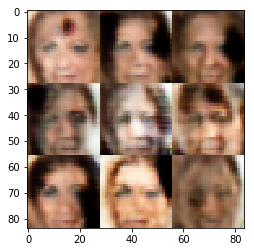

Epoch 1/1 - Step 760 Discriminator Loss: 1.4906  Generator Loss: 0.7051
Epoch 1/1 - Step 770 Discriminator Loss: 1.4136  Generator Loss: 0.8084
Epoch 1/1 - Step 780 Discriminator Loss: 1.5138  Generator Loss: 0.8106
Epoch 1/1 - Step 790 Discriminator Loss: 1.4820  Generator Loss: 0.7116
Epoch 1/1 - Step 800 Discriminator Loss: 1.4508  Generator Loss: 0.7918


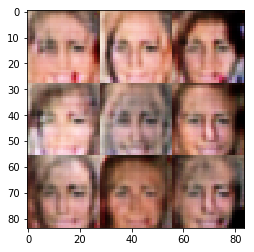

Epoch 1/1 - Step 810 Discriminator Loss: 1.4273  Generator Loss: 0.7054
Epoch 1/1 - Step 820 Discriminator Loss: 1.5088  Generator Loss: 0.7839
Epoch 1/1 - Step 830 Discriminator Loss: 1.3960  Generator Loss: 0.6937
Epoch 1/1 - Step 840 Discriminator Loss: 1.4407  Generator Loss: 0.7220
Epoch 1/1 - Step 850 Discriminator Loss: 1.4633  Generator Loss: 0.8776


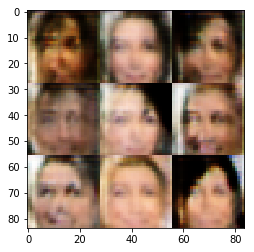

Epoch 1/1 - Step 860 Discriminator Loss: 1.6814  Generator Loss: 0.7025
Epoch 1/1 - Step 870 Discriminator Loss: 1.5112  Generator Loss: 0.8409
Epoch 1/1 - Step 880 Discriminator Loss: 1.5057  Generator Loss: 0.6798
Epoch 1/1 - Step 890 Discriminator Loss: 1.5762  Generator Loss: 0.8833
Epoch 1/1 - Step 900 Discriminator Loss: 1.4537  Generator Loss: 0.7015


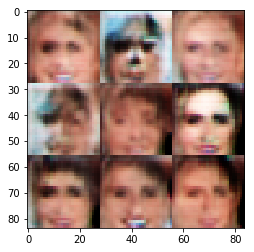

Epoch 1/1 - Step 910 Discriminator Loss: 1.4480  Generator Loss: 0.7728
Epoch 1/1 - Step 920 Discriminator Loss: 1.4874  Generator Loss: 0.7155
Epoch 1/1 - Step 930 Discriminator Loss: 1.4017  Generator Loss: 0.7814
Epoch 1/1 - Step 940 Discriminator Loss: 1.5134  Generator Loss: 0.6152
Epoch 1/1 - Step 950 Discriminator Loss: 1.4469  Generator Loss: 0.7719


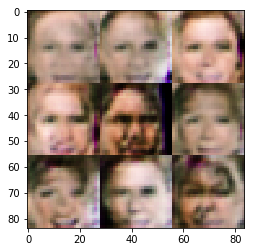

Epoch 1/1 - Step 960 Discriminator Loss: 1.4332  Generator Loss: 0.7610
Epoch 1/1 - Step 970 Discriminator Loss: 1.4212  Generator Loss: 0.7323
Epoch 1/1 - Step 980 Discriminator Loss: 1.5254  Generator Loss: 1.0068
Epoch 1/1 - Step 990 Discriminator Loss: 1.4198  Generator Loss: 0.7513
Epoch 1/1 - Step 1000 Discriminator Loss: 1.4267  Generator Loss: 0.7278


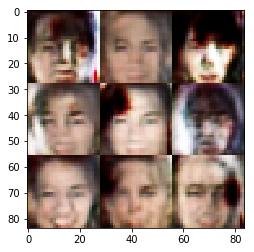

Epoch 1/1 - Step 1010 Discriminator Loss: 1.4885  Generator Loss: 0.8575
Epoch 1/1 - Step 1020 Discriminator Loss: 1.4286  Generator Loss: 0.7340
Epoch 1/1 - Step 1030 Discriminator Loss: 1.4752  Generator Loss: 0.6640
Epoch 1/1 - Step 1040 Discriminator Loss: 1.4508  Generator Loss: 0.7729
Epoch 1/1 - Step 1050 Discriminator Loss: 1.4206  Generator Loss: 0.8033


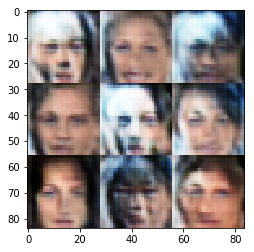

Epoch 1/1 - Step 1060 Discriminator Loss: 1.4502  Generator Loss: 0.7384
Epoch 1/1 - Step 1070 Discriminator Loss: 1.3922  Generator Loss: 0.7163
Epoch 1/1 - Step 1080 Discriminator Loss: 1.5083  Generator Loss: 0.7844
Epoch 1/1 - Step 1090 Discriminator Loss: 1.4113  Generator Loss: 0.8046
Epoch 1/1 - Step 1100 Discriminator Loss: 1.3839  Generator Loss: 0.7494


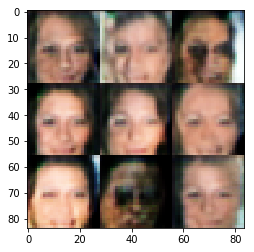

Epoch 1/1 - Step 1110 Discriminator Loss: 1.4404  Generator Loss: 0.6846
Epoch 1/1 - Step 1120 Discriminator Loss: 1.3935  Generator Loss: 0.7598
Epoch 1/1 - Step 1130 Discriminator Loss: 1.4079  Generator Loss: 0.7659
Epoch 1/1 - Step 1140 Discriminator Loss: 1.5077  Generator Loss: 0.7019
Epoch 1/1 - Step 1150 Discriminator Loss: 1.4336  Generator Loss: 0.7833


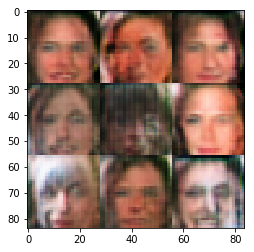

Epoch 1/1 - Step 1160 Discriminator Loss: 1.5206  Generator Loss: 0.7360
Epoch 1/1 - Step 1170 Discriminator Loss: 1.3964  Generator Loss: 0.8577
Epoch 1/1 - Step 1180 Discriminator Loss: 1.4590  Generator Loss: 0.7162
Epoch 1/1 - Step 1190 Discriminator Loss: 1.5515  Generator Loss: 0.6319
Epoch 1/1 - Step 1200 Discriminator Loss: 1.4810  Generator Loss: 0.8384


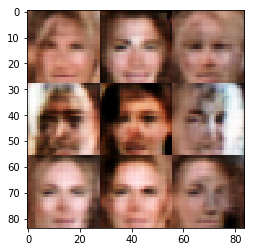

Epoch 1/1 - Step 1210 Discriminator Loss: 1.3920  Generator Loss: 0.7502
Epoch 1/1 - Step 1220 Discriminator Loss: 1.3368  Generator Loss: 0.8637
Epoch 1/1 - Step 1230 Discriminator Loss: 1.3819  Generator Loss: 0.7470
Epoch 1/1 - Step 1240 Discriminator Loss: 1.4349  Generator Loss: 0.7302
Epoch 1/1 - Step 1250 Discriminator Loss: 1.6182  Generator Loss: 0.6762


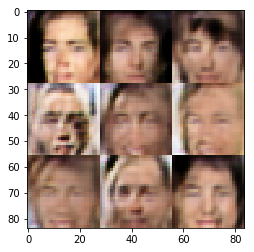

Epoch 1/1 - Step 1260 Discriminator Loss: 1.4542  Generator Loss: 0.8242
Epoch 1/1 - Step 1270 Discriminator Loss: 1.3988  Generator Loss: 0.7327
Epoch 1/1 - Step 1280 Discriminator Loss: 1.3708  Generator Loss: 0.7058
Epoch 1/1 - Step 1290 Discriminator Loss: 1.3982  Generator Loss: 0.7336
Epoch 1/1 - Step 1300 Discriminator Loss: 1.4148  Generator Loss: 0.7930


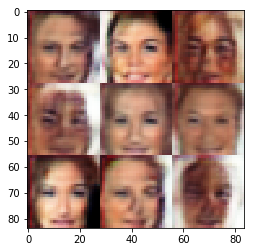

Epoch 1/1 - Step 1310 Discriminator Loss: 1.4166  Generator Loss: 0.7838
Epoch 1/1 - Step 1320 Discriminator Loss: 1.4201  Generator Loss: 0.7245
Epoch 1/1 - Step 1330 Discriminator Loss: 1.4490  Generator Loss: 0.7851
Epoch 1/1 - Step 1340 Discriminator Loss: 1.4094  Generator Loss: 0.8166
Epoch 1/1 - Step 1350 Discriminator Loss: 1.3974  Generator Loss: 0.7395


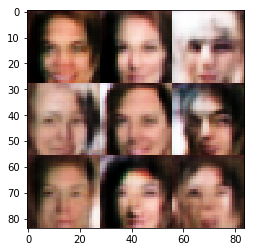

Epoch 1/1 - Step 1360 Discriminator Loss: 1.4230  Generator Loss: 0.8522
Epoch 1/1 - Step 1370 Discriminator Loss: 1.5265  Generator Loss: 0.6504
Epoch 1/1 - Step 1380 Discriminator Loss: 1.3791  Generator Loss: 0.7882
Epoch 1/1 - Step 1390 Discriminator Loss: 1.4569  Generator Loss: 0.8665
Epoch 1/1 - Step 1400 Discriminator Loss: 1.4581  Generator Loss: 0.7057


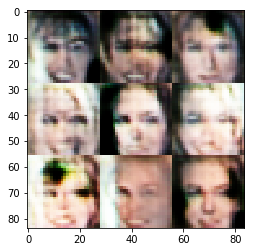

Epoch 1/1 - Step 1410 Discriminator Loss: 1.5052  Generator Loss: 0.8154
Epoch 1/1 - Step 1420 Discriminator Loss: 1.4592  Generator Loss: 0.8712
Epoch 1/1 - Step 1430 Discriminator Loss: 1.4769  Generator Loss: 0.6713
Epoch 1/1 - Step 1440 Discriminator Loss: 1.4609  Generator Loss: 0.7275
Epoch 1/1 - Step 1450 Discriminator Loss: 1.4617  Generator Loss: 0.7665


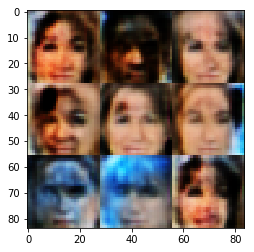

Epoch 1/1 - Step 1460 Discriminator Loss: 1.4655  Generator Loss: 0.8394
Epoch 1/1 - Step 1470 Discriminator Loss: 1.4430  Generator Loss: 0.8108
Epoch 1/1 - Step 1480 Discriminator Loss: 1.4550  Generator Loss: 0.6899
Epoch 1/1 - Step 1490 Discriminator Loss: 1.4528  Generator Loss: 0.7362
Epoch 1/1 - Step 1500 Discriminator Loss: 1.3960  Generator Loss: 0.7009


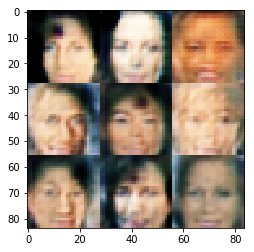

Epoch 1/1 - Step 1510 Discriminator Loss: 1.3951  Generator Loss: 0.7719
Epoch 1/1 - Step 1520 Discriminator Loss: 1.3625  Generator Loss: 0.7595
Epoch 1/1 - Step 1530 Discriminator Loss: 1.4437  Generator Loss: 0.8342
Epoch 1/1 - Step 1540 Discriminator Loss: 1.4364  Generator Loss: 0.7566
Epoch 1/1 - Step 1550 Discriminator Loss: 1.4757  Generator Loss: 0.7659


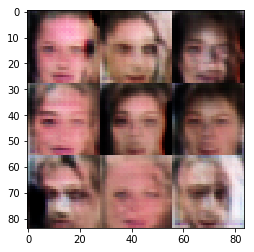

Epoch 1/1 - Step 1560 Discriminator Loss: 1.4753  Generator Loss: 0.6999
Epoch 1/1 - Step 1570 Discriminator Loss: 1.4914  Generator Loss: 0.7225
Epoch 1/1 - Step 1580 Discriminator Loss: 1.4665  Generator Loss: 0.6630
Epoch 1/1 - Step 1590 Discriminator Loss: 1.5098  Generator Loss: 0.7620
Epoch 1/1 - Step 1600 Discriminator Loss: 1.3566  Generator Loss: 0.7766


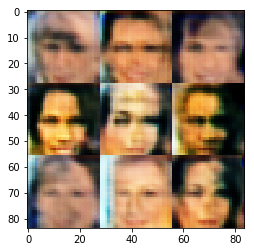

Epoch 1/1 - Step 1610 Discriminator Loss: 1.4681  Generator Loss: 0.7123
Epoch 1/1 - Step 1620 Discriminator Loss: 1.4271  Generator Loss: 0.7497
Epoch 1/1 - Step 1630 Discriminator Loss: 1.4080  Generator Loss: 0.7779
Epoch 1/1 - Step 1640 Discriminator Loss: 1.3844  Generator Loss: 0.8431
Epoch 1/1 - Step 1650 Discriminator Loss: 1.4256  Generator Loss: 0.7218


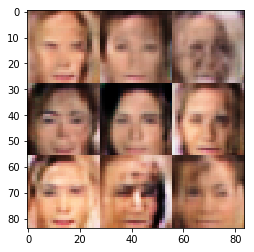

Epoch 1/1 - Step 1660 Discriminator Loss: 1.4428  Generator Loss: 0.8255
Epoch 1/1 - Step 1670 Discriminator Loss: 1.4428  Generator Loss: 0.7620
Epoch 1/1 - Step 1680 Discriminator Loss: 1.3954  Generator Loss: 0.9125
Epoch 1/1 - Step 1690 Discriminator Loss: 1.3939  Generator Loss: 0.7632
Epoch 1/1 - Step 1700 Discriminator Loss: 1.4046  Generator Loss: 0.6915


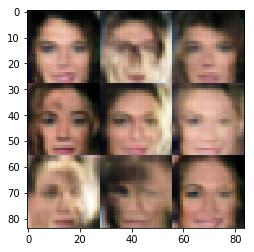

Epoch 1/1 - Step 1710 Discriminator Loss: 1.4249  Generator Loss: 0.7115
Epoch 1/1 - Step 1720 Discriminator Loss: 1.4520  Generator Loss: 0.6864
Epoch 1/1 - Step 1730 Discriminator Loss: 1.4119  Generator Loss: 0.7782
Epoch 1/1 - Step 1740 Discriminator Loss: 1.4108  Generator Loss: 0.7553
Epoch 1/1 - Step 1750 Discriminator Loss: 1.4155  Generator Loss: 0.7552


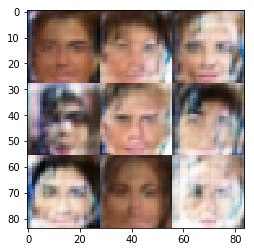

Epoch 1/1 - Step 1760 Discriminator Loss: 1.4220  Generator Loss: 0.7568
Epoch 1/1 - Step 1770 Discriminator Loss: 1.5282  Generator Loss: 1.0005
Epoch 1/1 - Step 1780 Discriminator Loss: 1.4725  Generator Loss: 0.7869
Epoch 1/1 - Step 1790 Discriminator Loss: 1.4680  Generator Loss: 0.6001
Epoch 1/1 - Step 1800 Discriminator Loss: 1.4317  Generator Loss: 0.6835


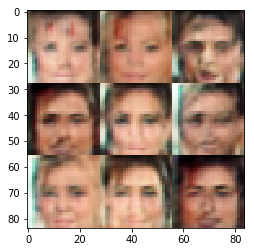

Epoch 1/1 - Step 1810 Discriminator Loss: 1.4399  Generator Loss: 0.7637
Epoch 1/1 - Step 1820 Discriminator Loss: 1.4569  Generator Loss: 0.8613
Epoch 1/1 - Step 1830 Discriminator Loss: 1.4276  Generator Loss: 0.6812
Epoch 1/1 - Step 1840 Discriminator Loss: 1.4934  Generator Loss: 0.7228
Epoch 1/1 - Step 1850 Discriminator Loss: 1.4989  Generator Loss: 0.8365


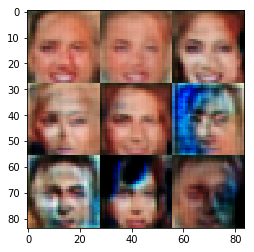

Epoch 1/1 - Step 1860 Discriminator Loss: 1.4228  Generator Loss: 0.8477
Epoch 1/1 - Step 1870 Discriminator Loss: 1.4514  Generator Loss: 0.7562
Epoch 1/1 - Step 1880 Discriminator Loss: 1.4554  Generator Loss: 0.8486
Epoch 1/1 - Step 1890 Discriminator Loss: 1.4287  Generator Loss: 0.7349
Epoch 1/1 - Step 1900 Discriminator Loss: 1.4079  Generator Loss: 0.6835


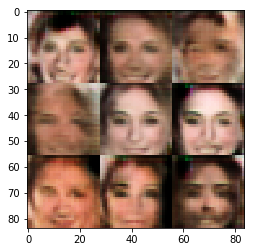

Epoch 1/1 - Step 1910 Discriminator Loss: 1.4520  Generator Loss: 0.7562
Epoch 1/1 - Step 1920 Discriminator Loss: 1.3998  Generator Loss: 0.7406
Epoch 1/1 - Step 1930 Discriminator Loss: 1.5052  Generator Loss: 0.7903
Epoch 1/1 - Step 1940 Discriminator Loss: 1.4476  Generator Loss: 0.8626
Epoch 1/1 - Step 1950 Discriminator Loss: 1.3688  Generator Loss: 0.6721


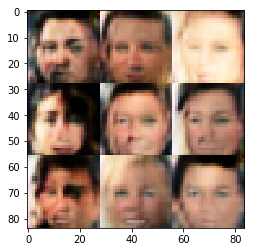

Epoch 1/1 - Step 1960 Discriminator Loss: 1.3990  Generator Loss: 0.7893
Epoch 1/1 - Step 1970 Discriminator Loss: 1.4634  Generator Loss: 0.7016
Epoch 1/1 - Step 1980 Discriminator Loss: 1.4362  Generator Loss: 0.7250
Epoch 1/1 - Step 1990 Discriminator Loss: 1.4230  Generator Loss: 0.7882
Epoch 1/1 - Step 2000 Discriminator Loss: 1.3942  Generator Loss: 0.7701


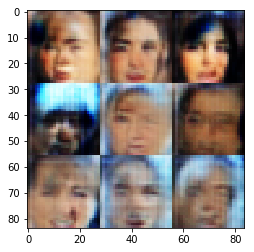

Epoch 1/1 - Step 2010 Discriminator Loss: 1.3445  Generator Loss: 0.8481
Epoch 1/1 - Step 2020 Discriminator Loss: 1.4048  Generator Loss: 0.8460
Epoch 1/1 - Step 2030 Discriminator Loss: 1.4528  Generator Loss: 0.7226
Epoch 1/1 - Step 2040 Discriminator Loss: 1.4247  Generator Loss: 0.7446
Epoch 1/1 - Step 2050 Discriminator Loss: 1.3862  Generator Loss: 0.7975


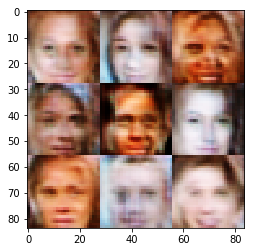

Epoch 1/1 - Step 2060 Discriminator Loss: 1.4202  Generator Loss: 0.7760
Epoch 1/1 - Step 2070 Discriminator Loss: 1.4478  Generator Loss: 0.7880
Epoch 1/1 - Step 2080 Discriminator Loss: 1.4513  Generator Loss: 0.7801
Epoch 1/1 - Step 2090 Discriminator Loss: 1.5613  Generator Loss: 0.7450
Epoch 1/1 - Step 2100 Discriminator Loss: 1.4450  Generator Loss: 0.8057


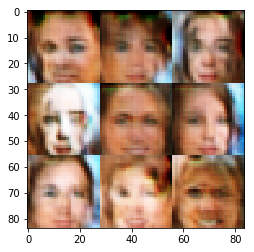

Epoch 1/1 - Step 2110 Discriminator Loss: 1.4043  Generator Loss: 0.8473
Epoch 1/1 - Step 2120 Discriminator Loss: 1.4177  Generator Loss: 0.7741
Epoch 1/1 - Step 2130 Discriminator Loss: 1.4438  Generator Loss: 0.7955
Epoch 1/1 - Step 2140 Discriminator Loss: 1.4609  Generator Loss: 0.7733
Epoch 1/1 - Step 2150 Discriminator Loss: 1.4060  Generator Loss: 0.8647


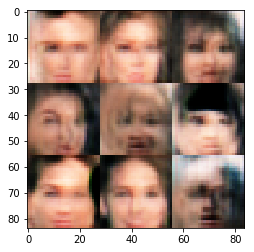

Epoch 1/1 - Step 2160 Discriminator Loss: 1.3774  Generator Loss: 0.7502
Epoch 1/1 - Step 2170 Discriminator Loss: 1.4292  Generator Loss: 0.6966
Epoch 1/1 - Step 2180 Discriminator Loss: 1.4562  Generator Loss: 0.6956
Epoch 1/1 - Step 2190 Discriminator Loss: 1.4949  Generator Loss: 0.7095
Epoch 1/1 - Step 2200 Discriminator Loss: 1.5045  Generator Loss: 0.6849


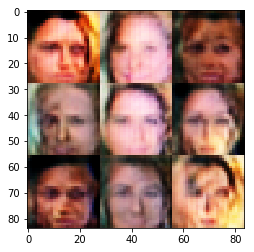

Epoch 1/1 - Step 2210 Discriminator Loss: 1.4265  Generator Loss: 0.6759
Epoch 1/1 - Step 2220 Discriminator Loss: 1.3759  Generator Loss: 0.7782
Epoch 1/1 - Step 2230 Discriminator Loss: 1.4305  Generator Loss: 0.6839
Epoch 1/1 - Step 2240 Discriminator Loss: 1.3866  Generator Loss: 0.7507
Epoch 1/1 - Step 2250 Discriminator Loss: 1.4357  Generator Loss: 0.7335


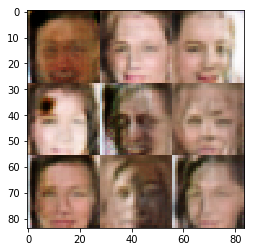

Epoch 1/1 - Step 2260 Discriminator Loss: 1.4118  Generator Loss: 0.7489
Epoch 1/1 - Step 2270 Discriminator Loss: 1.4972  Generator Loss: 0.8458
Epoch 1/1 - Step 2280 Discriminator Loss: 1.4561  Generator Loss: 0.6451
Epoch 1/1 - Step 2290 Discriminator Loss: 1.4534  Generator Loss: 0.7313
Epoch 1/1 - Step 2300 Discriminator Loss: 1.3916  Generator Loss: 0.7550


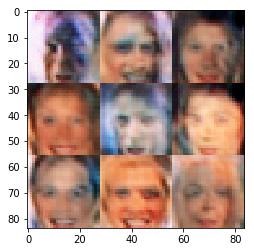

Epoch 1/1 - Step 2310 Discriminator Loss: 1.3956  Generator Loss: 0.7745
Epoch 1/1 - Step 2320 Discriminator Loss: 1.3942  Generator Loss: 0.8039
Epoch 1/1 - Step 2330 Discriminator Loss: 1.4592  Generator Loss: 0.6964
Epoch 1/1 - Step 2340 Discriminator Loss: 1.4014  Generator Loss: 0.8590
Epoch 1/1 - Step 2350 Discriminator Loss: 1.4089  Generator Loss: 0.7185


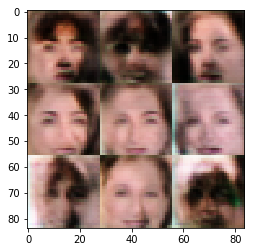

Epoch 1/1 - Step 2360 Discriminator Loss: 1.4320  Generator Loss: 0.6873
Epoch 1/1 - Step 2370 Discriminator Loss: 1.3652  Generator Loss: 0.7254
Epoch 1/1 - Step 2380 Discriminator Loss: 1.4432  Generator Loss: 0.7942
Epoch 1/1 - Step 2390 Discriminator Loss: 1.3944  Generator Loss: 0.7369
Epoch 1/1 - Step 2400 Discriminator Loss: 1.4361  Generator Loss: 0.7403


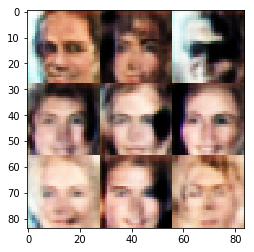

Epoch 1/1 - Step 2410 Discriminator Loss: 1.4402  Generator Loss: 0.8113
Epoch 1/1 - Step 2420 Discriminator Loss: 1.4138  Generator Loss: 0.7534
Epoch 1/1 - Step 2430 Discriminator Loss: 1.3940  Generator Loss: 0.6766
Epoch 1/1 - Step 2440 Discriminator Loss: 1.4107  Generator Loss: 0.7803
Epoch 1/1 - Step 2450 Discriminator Loss: 1.4139  Generator Loss: 0.7778


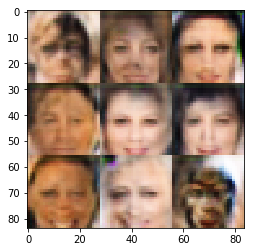

Epoch 1/1 - Step 2460 Discriminator Loss: 1.4024  Generator Loss: 0.6514
Epoch 1/1 - Step 2470 Discriminator Loss: 1.3793  Generator Loss: 0.7672
Epoch 1/1 - Step 2480 Discriminator Loss: 1.4123  Generator Loss: 0.7105
Epoch 1/1 - Step 2490 Discriminator Loss: 1.5039  Generator Loss: 0.9260
Epoch 1/1 - Step 2500 Discriminator Loss: 1.4285  Generator Loss: 0.8371


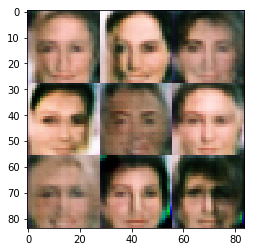

Epoch 1/1 - Step 2510 Discriminator Loss: 1.4790  Generator Loss: 0.6905
Epoch 1/1 - Step 2520 Discriminator Loss: 1.3662  Generator Loss: 0.7262
Epoch 1/1 - Step 2530 Discriminator Loss: 1.4216  Generator Loss: 0.8081
Epoch 1/1 - Step 2540 Discriminator Loss: 1.4429  Generator Loss: 0.6699
Epoch 1/1 - Step 2550 Discriminator Loss: 1.4564  Generator Loss: 0.7653


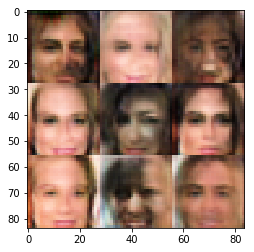

Epoch 1/1 - Step 2560 Discriminator Loss: 1.4458  Generator Loss: 0.8048
Epoch 1/1 - Step 2570 Discriminator Loss: 1.5119  Generator Loss: 0.7660
Epoch 1/1 - Step 2580 Discriminator Loss: 1.4262  Generator Loss: 0.7295
Epoch 1/1 - Step 2590 Discriminator Loss: 1.4018  Generator Loss: 0.7019
Epoch 1/1 - Step 2600 Discriminator Loss: 1.4158  Generator Loss: 0.7878


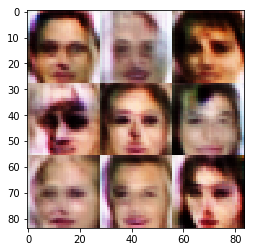

Epoch 1/1 - Step 2610 Discriminator Loss: 1.4468  Generator Loss: 0.6774
Epoch 1/1 - Step 2620 Discriminator Loss: 1.3894  Generator Loss: 0.7382
Epoch 1/1 - Step 2630 Discriminator Loss: 1.4348  Generator Loss: 0.7516
Epoch 1/1 - Step 2640 Discriminator Loss: 1.4068  Generator Loss: 0.8512
Epoch 1/1 - Step 2650 Discriminator Loss: 1.3638  Generator Loss: 0.8787


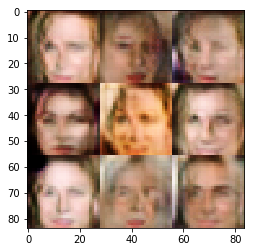

Epoch 1/1 - Step 2660 Discriminator Loss: 1.4598  Generator Loss: 0.8910
Epoch 1/1 - Step 2670 Discriminator Loss: 1.4254  Generator Loss: 0.7535
Epoch 1/1 - Step 2680 Discriminator Loss: 1.4339  Generator Loss: 0.7962
Epoch 1/1 - Step 2690 Discriminator Loss: 1.4114  Generator Loss: 0.7543
Epoch 1/1 - Step 2700 Discriminator Loss: 1.4139  Generator Loss: 0.7236


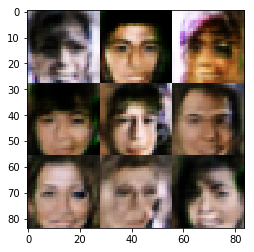

Epoch 1/1 - Step 2710 Discriminator Loss: 1.4633  Generator Loss: 0.7979
Epoch 1/1 - Step 2720 Discriminator Loss: 1.4207  Generator Loss: 0.7729
Epoch 1/1 - Step 2730 Discriminator Loss: 1.3775  Generator Loss: 0.7903
Epoch 1/1 - Step 2740 Discriminator Loss: 1.3886  Generator Loss: 0.7440
Epoch 1/1 - Step 2750 Discriminator Loss: 1.4143  Generator Loss: 0.7656


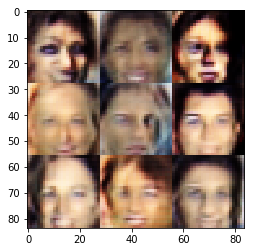

Epoch 1/1 - Step 2760 Discriminator Loss: 1.4628  Generator Loss: 0.8587
Epoch 1/1 - Step 2770 Discriminator Loss: 1.3985  Generator Loss: 0.8115
Epoch 1/1 - Step 2780 Discriminator Loss: 1.4270  Generator Loss: 0.7609
Epoch 1/1 - Step 2790 Discriminator Loss: 1.3869  Generator Loss: 0.8111
Epoch 1/1 - Step 2800 Discriminator Loss: 1.4091  Generator Loss: 0.7116


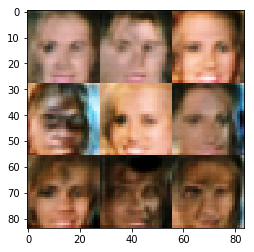

Epoch 1/1 - Step 2810 Discriminator Loss: 1.4265  Generator Loss: 0.8284
Epoch 1/1 - Step 2820 Discriminator Loss: 1.4342  Generator Loss: 0.7634
Epoch 1/1 - Step 2830 Discriminator Loss: 1.4808  Generator Loss: 0.7617
Epoch 1/1 - Step 2840 Discriminator Loss: 1.4371  Generator Loss: 0.7843
Epoch 1/1 - Step 2850 Discriminator Loss: 1.3946  Generator Loss: 0.9056


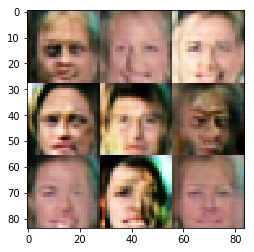

Epoch 1/1 - Step 2860 Discriminator Loss: 1.4056  Generator Loss: 0.8090
Epoch 1/1 - Step 2870 Discriminator Loss: 1.4373  Generator Loss: 0.7750
Epoch 1/1 - Step 2880 Discriminator Loss: 1.4278  Generator Loss: 0.8242
Epoch 1/1 - Step 2890 Discriminator Loss: 1.4359  Generator Loss: 0.7555
Epoch 1/1 - Step 2900 Discriminator Loss: 1.4294  Generator Loss: 0.7801


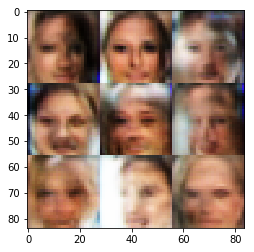

Epoch 1/1 - Step 2910 Discriminator Loss: 1.4190  Generator Loss: 0.7843
Epoch 1/1 - Step 2920 Discriminator Loss: 1.4236  Generator Loss: 0.8035
Epoch 1/1 - Step 2930 Discriminator Loss: 1.4048  Generator Loss: 0.7773
Epoch 1/1 - Step 2940 Discriminator Loss: 1.4078  Generator Loss: 0.8850
Epoch 1/1 - Step 2950 Discriminator Loss: 1.4088  Generator Loss: 0.7429


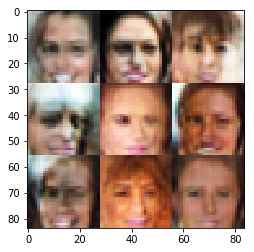

Epoch 1/1 - Step 2960 Discriminator Loss: 1.4208  Generator Loss: 0.7205
Epoch 1/1 - Step 2970 Discriminator Loss: 1.4248  Generator Loss: 0.7658
Epoch 1/1 - Step 2980 Discriminator Loss: 1.4232  Generator Loss: 0.7833
Epoch 1/1 - Step 2990 Discriminator Loss: 1.4108  Generator Loss: 0.8213
Epoch 1/1 - Step 3000 Discriminator Loss: 1.4279  Generator Loss: 0.8094


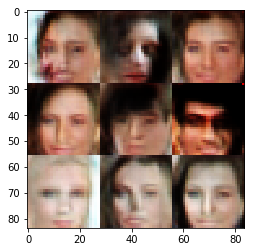

Epoch 1/1 - Step 3010 Discriminator Loss: 1.4159  Generator Loss: 0.7335
Epoch 1/1 - Step 3020 Discriminator Loss: 1.3483  Generator Loss: 0.8285
Epoch 1/1 - Step 3030 Discriminator Loss: 1.4975  Generator Loss: 0.6525
Epoch 1/1 - Step 3040 Discriminator Loss: 1.4360  Generator Loss: 0.8202
Epoch 1/1 - Step 3050 Discriminator Loss: 1.4358  Generator Loss: 0.8124


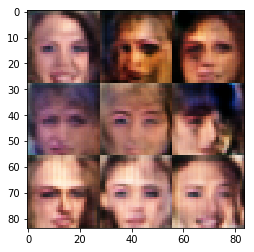

Epoch 1/1 - Step 3060 Discriminator Loss: 1.4449  Generator Loss: 0.7611
Epoch 1/1 - Step 3070 Discriminator Loss: 1.3870  Generator Loss: 0.7310
Epoch 1/1 - Step 3080 Discriminator Loss: 1.3661  Generator Loss: 0.8010
Epoch 1/1 - Step 3090 Discriminator Loss: 1.4175  Generator Loss: 0.8204
Epoch 1/1 - Step 3100 Discriminator Loss: 1.4348  Generator Loss: 0.9031


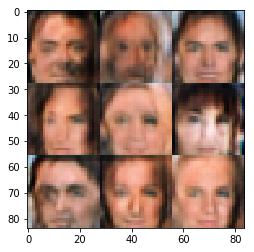

Epoch 1/1 - Step 3110 Discriminator Loss: 1.4395  Generator Loss: 0.7996
Epoch 1/1 - Step 3120 Discriminator Loss: 1.3987  Generator Loss: 0.7736
Epoch 1/1 - Step 3130 Discriminator Loss: 1.4616  Generator Loss: 0.7703
Epoch 1/1 - Step 3140 Discriminator Loss: 1.4385  Generator Loss: 0.8661
Epoch 1/1 - Step 3150 Discriminator Loss: 1.4055  Generator Loss: 0.9093


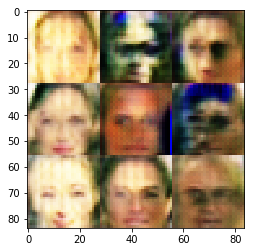

Epoch 1/1 - Step 3160 Discriminator Loss: 1.4212  Generator Loss: 0.8086


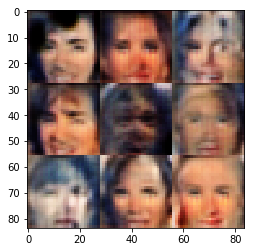

In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.